In [1]:
import pyspark
from pyspark.sql import SparkSession

In [2]:
spark=SparkSession.builder.appName("Project").getOrCreate()
df=spark.read.csv('hotel_bookings.csv', sep =',', header = True,inferSchema=True)

In [4]:
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [5]:
df.count()

119390

# FEATURE SELECTION

Đối với bài toán này ta cần lựa chọn các feature có đóng góp ý nghĩa đối với việc hủy phòng và loại bỏ các feature còn lại để
giảm bớt độ phức tạp cho mô hình

  - company và agent:  việc đặt phòng qua công ty hoặc đại lý nào ít ảnh hưởng đến quyết định hủy phòng của khách hàng nên ta bỏ luôn hai cột này
  - country: bỏ luôn cột này vì trên thực tế yếu tố địa lý cũng rất ít ảnh hưởng đến quyết định hủy phòng.
  - Hotel: Phân tích biểu đồ tỉ lệ phần trăm hủy bỏ đối mỗi tháng của 2 loại khách sạn sẽ thấy sự khác nhau khi loại resort sẽ bị hủy nhiều hơn vào mùa hè chứng tỏ hai thuộc tính hotel và arrival_date_month cùng tác động đến tỉ lệ canceled (chưa vẽ được biểu đồ)
  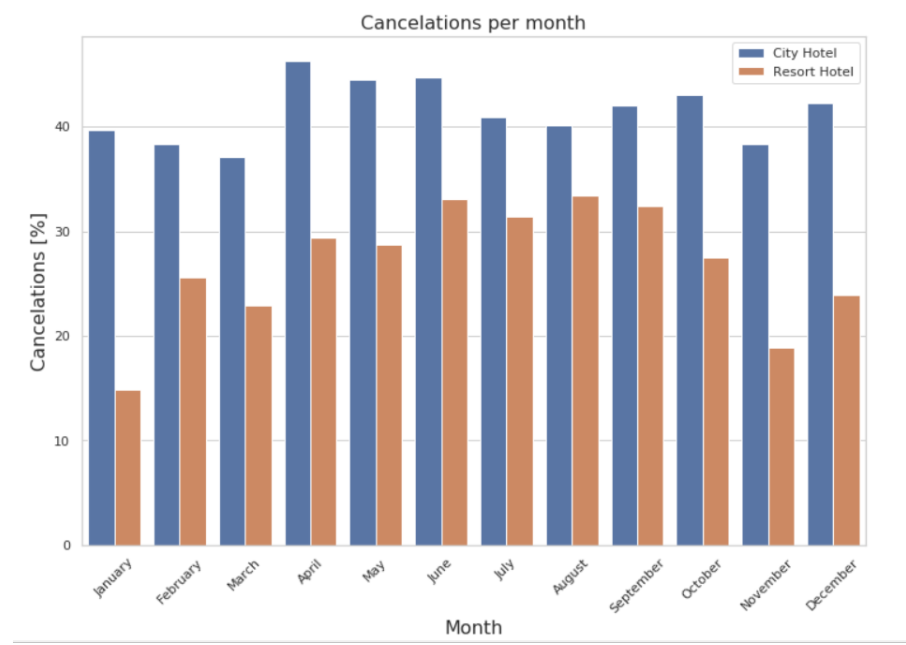

  - lead_time: ta có thể nhận thấy rằng trong thực tế những người đặt khách sạn càng gần thời gian đến sẽ có xu hướng khó hủy hơn so với những người đặt từ lâu. Điều này là hợp lí nên lead_time cũng được chọn    
  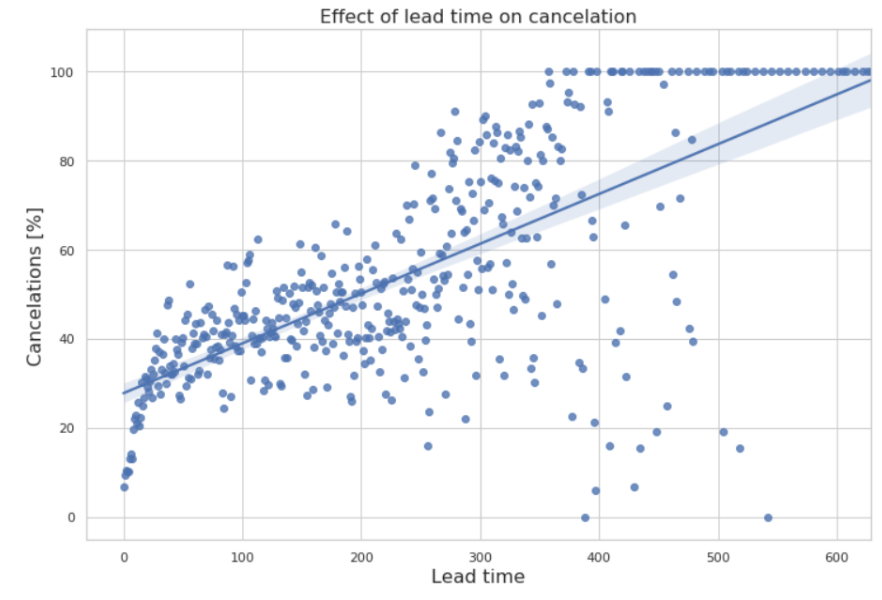

<AxesSubplot:xlabel='is_canceled', ylabel='days_in_waiting_list'>

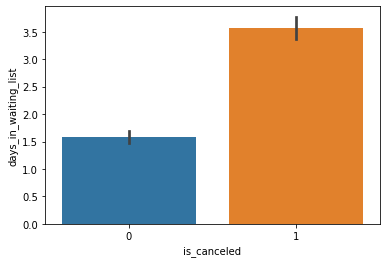

In [27]:
#Biểu diễu ngày đợi của khách hàng
import seaborn as sns
sns.barplot(x = "is_canceled", y = "days_in_waiting_list",data = df.toPandas())

<AxesSubplot:title={'center':'Count of deposit type'}, xlabel='deposit_type', ylabel='count'>

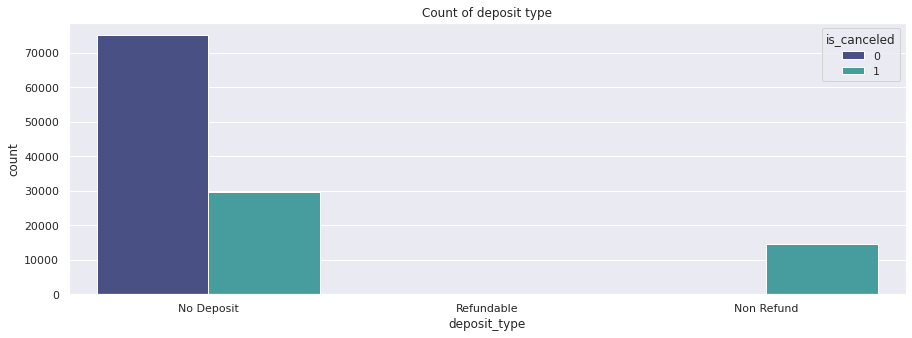

In [28]:
import calendar
sns.set(style = "darkgrid")
plt.figure(figsize=(15, 5));
plt.title("Count of deposit type")
sns.countplot(x='deposit_type', hue='is_canceled', palette="mako",data = df.toPandas())

<AxesSubplot:title={'center':'Count of require car'}, xlabel='required_car_parking_spaces', ylabel='count'>

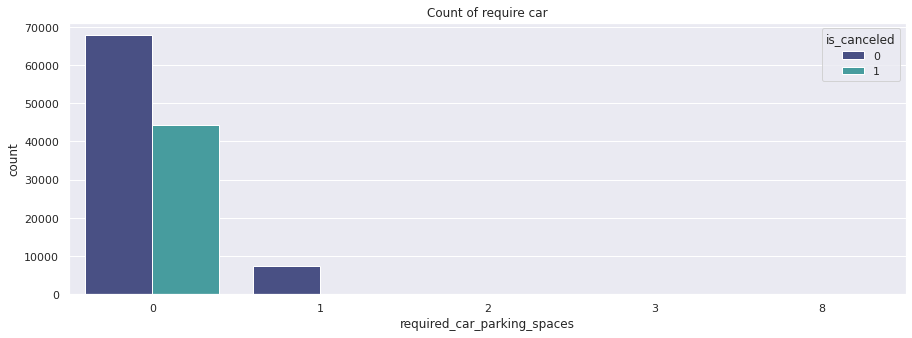

In [29]:
import calendar
sns.set(style = "darkgrid")
plt.figure(figsize=(15, 5));
plt.title("Count of require car")
sns.countplot(x='required_car_parking_spaces', hue='is_canceled', palette="mako",data = df.toPandas())

In [9]:
len(selected_df.columns)

18

# DATA CLEANING

In [10]:
#Kiểm tra data có duplicates không.
selected_df.distinct().count()

78566

In [11]:
selected_df=selected_df.drop_duplicates()
selected_df.count()

78566

In [12]:
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

#Kiểm tra giá trị NULL
Col_Null={col:selected_df.filter(upper(df[col]).contains('NULL') | df[col].contains('NA')).count() for col in selected_df.columns}
Col_Null

{'hotel': 0,
 'is_canceled': 0,
 'lead_time': 0,
 'arrival_date_month': 0,
 'stays_in_weekend_nights': 0,
 'stays_in_week_nights': 0,
 'adults': 0,
 'children': 4,
 'babies': 0,
 'meal': 0,
 'market_segment': 0,
 'distribution_channel': 0,
 'previous_cancellations': 0,
 'previous_bookings_not_canceled': 0,
 'booking_changes': 0,
 'customer_type': 0,
 'required_car_parking_spaces': 0,
 'total_of_special_requests': 0}

In [13]:
#Xóa giá trị null ở cột children
selected_df = selected_df.where(df.children!='NA')
selected_df.groupBy('children').count().show()

+--------+-----+
|children|count|
+--------+-----+
|       3|   74|
|       0|70390|
|       1| 4574|
|      10|    1|
|       2| 3523|
+--------+-----+



In [14]:
from pyspark.sql.functions import regexp_replace

#ở cột meal có một số giá trị là "Undefined" chưa được chuyển đổi thành "SC" theo mô tả ở dataset
selected_df=selected_df.withColumn('meal', regexp_replace('meal', 'Undefined', 'SC'))
selected_df.groupBy('meal').count().show()

+----+-----+
|meal|count|
+----+-----+
|  SC| 9140|
|  FB|  340|
|  BB|60796|
|  HB| 8286|
+----+-----+



In [15]:
#ở cột market_segment có một số giá trị là "Undefined"  được chuyển đổi thành "Online TA" (chọn giá trị xuất hiện nhiều nhất)
selected_df=selected_df.withColumn('market_segment', regexp_replace('market_segment', 'Undefined', 'Online TA'))
selected_df.groupBy('market_segment').count().show()

+--------------+-----+
|market_segment|count|
+--------------+-----+
| Offline TA/TO|12328|
| Complementary|  672|
|      Aviation|  197|
|        Direct|10211|
|     Corporate| 3655|
|     Online TA|47950|
|        Groups| 3549|
+--------------+-----+



#ở cột distribution_chanel có một số giá trị là "Undefined"  được chuyển đổi thành "TA/TO"  (chọn giá trị xuất hiện nhiều nhất)
selected_df=selected_df.withColumn('distribution_channel', regexp_replace('distribution_channel', 'Undefined', 'TA/TO'))
selected_df.groupBy('distribution_channel').count().show()

In [16]:
#một số hàng chứa 0 adults, 0 children and 0 babies, ta nên loại bỏ một số hàng này vì nó có thể được xem là nhiễu
#đếm số hàng cả 3 giá trị đều bằng 0
selected_df.filter((df.adults==0) & (df.children==0) & (df.babies==0)).count()

159

In [17]:
#Loại bỏ tất cả hàng có 3 giá trị đều bằng 0 
selected_df = selected_df.where((selected_df.adults!=0) | (selected_df.children!=0) | (selected_df.babies!=0))

In [18]:
selected_df.count()

78403

In [19]:
selected_df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- booking_changes: integer (nullable = true)
 |-- customer_type: string (nullable = true)
 |-- required_car_parking_spaces: integer (nullable = true)
 |-- total_of_special_requests: integer (nullable = true)



In [20]:
from pyspark.sql.types import *
#Sửa đổi kiểu dữ liệu
#Thuộc tính children nên chuyển về kiểu dữ liệu int
selected_df = selected_df.withColumn('children',selected_df['children'].cast(IntegerType()))

In [21]:
len(selected_df.columns)

18

Sau khi làm sạch dữ liệu chúng ta còn 18 cột và 78403 hàng

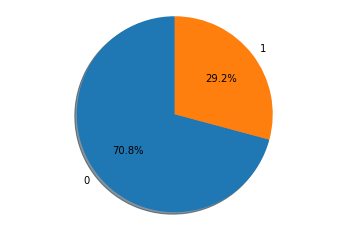

In [25]:
import matplotlib.pyplot as plt 

total_count=selected_df.count()
# 1 là hủy, 0 là không!
label=['0','1']
percentages=map(lambda label: selected_df.where('is_canceled ="{}"'.format(label)).count()/total_count,label)
percentages=list(percentages)
fig,ax=plt.subplots()
ax.pie(percentages,labels=label,autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis('equal')
plt.show()

# DATA ENGINEER

In [30]:
# chuyển đổi biến categorical thành các biến giả / chỉ số.
meal=selected_df.select('meal').distinct().rdd.flatMap(lambda x:x).collect()
market_segment=selected_df.select('market_segment').distinct().rdd.flatMap(lambda x:x).collect()
distribution_channel=selected_df.select('distribution_channel').distinct().rdd.flatMap(lambda x:x).collect()
customer_type=selected_df.select('customer_type').distinct().rdd.flatMap(lambda x:x).collect()
hotel=selected_df.select('hotel').distinct().rdd.flatMap(lambda x:x).collect()


In [31]:
#Convert one hot encoding
import pyspark.sql.functions as F
convert_meal = [F.when(F.col("meal") == x, 1).otherwise(0).alias("meal_" + x) for x in meal]
convert_market= [F.when(F.col("market_segment") == x, 1).otherwise(0).alias("market_segment_" + x) for x in market_segment]
convert_channel = [F.when(F.col("distribution_channel") == x, 1).otherwise(0).alias("distribution_channel_" + x) for x in distribution_channel]
convert_custype = [F.when(F.col("customer_type") == x, 1).otherwise(0).alias("customer_type_" + x) for x in customer_type]
convert_hotel = [F.when(F.col("hotel") == x, 1).otherwise(0).alias("hotel_" + x) for x in hotel]

In [32]:
data = selected_df.select(
 'is_canceled',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'booking_changes',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'required_car_parking_spaces',
 'total_of_special_requests', *convert_meal+convert_market+convert_channel+convert_custype+convert_hotel)

In [33]:
#Chuyển tháng từ categrocial thành numeric
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf, struct,col
month_dict={'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12 }
#Convert Month qua số để chạy model
user_func =  udf (lambda x: month_dict[x])
data=data.withColumn('arrival_date_month',user_func(col('arrival_date_month')))
#Cast tháng sang integer (1->12)
data = data.withColumn('arrival_date_month',data['arrival_date_month'].cast(IntegerType()))

In [34]:
numeric_features = ['lead_time',
                    'arrival_date_month',
                    'stays_in_weekend_nights',
                    'stays_in_week_nights',
                    'adults',
                    'children',
                    'babies',
                    'booking_changes',
                    'total_of_special_requests',
                    'required_car_parking_spaces',
                    'previous_cancellations',
                    'previous_bookings_not_canceled']

numeric_summary = data.select(numeric_features).describe().toPandas().transpose()

In [35]:
numeric_summary

,0,1,2,3,4
summary,count,mean,stddev,min,max
lead_time,78403,80.98801066285729,84.64041563161284,0,737
arrival_date_month,78403,6.489917477647539,3.073844321423939,1,12
stays_in_weekend_nights,78403,1.0406744639873475,1.0357582721198224,0,19
stays_in_week_nights,78403,2.6941826205629886,2.0681558572670973,0,50
adults,78403,1.8962922337155466,0.6334122618775738,0,55
children,78403,0.1511676849100162,0.4743404470453174,0,10
babies,78403,0.011989337142711377,0.11956028247266473,0,10
booking_changes,78403,0.2789561623917452,0.7315143604283494,0,18
total_of_special_requests,78403,0.7293215820823182,0.8434640653198379,0,5


In [36]:
#min-max scaler
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc.broadcast(numeric_summary)

#Lọc ra các numeric features
numeric_df = data.select(numeric_features)

#Tính min-max scaler : (x - min)/ (max - min)
rdd1 = numeric_df.rdd.map(list).map(lambda x: list(float(x[i]-float(numeric_summary[3][i+1]))/float(float(numeric_summary[4][i+1])-float(numeric_summary[3][i+1])) 
                                                               for i in range(len(x))))

#chuyển thành dataframe
numeric_df = rdd1.toDF(numeric_features)

# Đổi tên cho columns
cols = numeric_df.columns
for i in range(len(numeric_df.columns)):
    numeric_df=numeric_df.withColumnRenamed(numeric_df.columns[i],cols[i])

In [37]:
numeric_df

DataFrame[lead_time: double, arrival_date_month: double, stays_in_weekend_nights: double, stays_in_week_nights: double, adults: double, children: double, babies: double, booking_changes: double, total_of_special_requests: double, required_car_parking_spaces: double, previous_cancellations: double, previous_bookings_not_canceled: double]

In [38]:
ori_data = data.select('is_canceled',
 'meal_SC',
 'meal_FB',
 'meal_BB',
 'meal_HB',
 'market_segment_Offline TA/TO',
 'market_segment_Complementary',
 'market_segment_Aviation',
 'market_segment_Direct',
 'market_segment_Corporate',
 'market_segment_Online TA',
 'market_segment_Groups',
 'distribution_channel_TA/TO',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_Corporate',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'customer_type_Group',
 'customer_type_Contract',
 'hotel_City Hotel',
 'hotel_Resort Hotel')

from pyspark.sql.functions import monotonically_increasing_id

DF1 = ori_data.withColumn("row_id", monotonically_increasing_id())
DF2 = numeric_df.withColumn("row_id", monotonically_increasing_id())
result_df = DF1.join(DF2, ("row_id")).drop("row_id")

In [39]:
#Thêm bias 
from pyspark.sql.functions import lit
result_df = result_df.withColumn("bias",lit(1.0))

In [40]:
result_df.toPandas().head()

,is_canceled,meal_SC,meal_FB,meal_BB,meal_HB,market_segment_Offline TA/TO,market_segment_Complementary,market_segment_Aviation,market_segment_Direct,market_segment_Corporate,...,stays_in_week_nights,adults,children,babies,booking_changes,total_of_special_requests,required_car_parking_spaces,previous_cancellations,previous_bookings_not_canceled,bias
0,0,0,0,1,0,0,0,0,0,0,...,0.20,0.036364,0.0,0.0,0.055556,0.2,0.0,0.0,0.0,1.0
1,0,0,0,1,0,0,0,0,0,0,...,0.02,0.036364,0.0,0.0,0.000000,0.4,0.0,0.0,0.0,1.0
2,0,0,0,1,0,0,0,0,1,0,...,0.06,0.018182,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,1.0
3,1,0,0,1,0,0,0,0,0,0,...,0.10,0.036364,0.0,0.0,0.000000,0.2,0.0,0.0,0.0,1.0
4,1,0,0,1,0,0,0,0,0,0,...,0.08,0.036364,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0


In [41]:
#save lại file pandas
result_df.toPandas().to_csv('./engineered_df_finallll.csv',index=False)

# Thuật toán Logistics regression   

In [42]:
#load file csv đã engineer để tiện quá trình train
result_df = spark.read.csv('./engineered_df_finallll.csv', sep =',', header = True,inferSchema=True)

In [43]:
result_df.groupBy('is_canceled').count().show()

+-----------+-----+
|is_canceled|count|
+-----------+-----+
|          1|22872|
|          0|55531|
+-----------+-----+



In [44]:
#Chia tập train,test tỉ lệ 8:2
training, test = result_df.randomSplit([0.8, 0.2])

In [45]:
training.count()

62730

In [46]:
test.count()

15673

In [47]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [48]:
# Cross Entropy - dùng để kiểm tra quá trình map reduce
def compute_cost(X,theta,m):
    tol = 1e-9
    # zi, yi
    rdd1 = X.map(lambda p:(sigmoid(np.dot(np.array(p[0]),np.array(theta))),p[1]))
    # ji(w)
    rdd2 = rdd1.map(lambda p: (p[1]*np.log(p[0] if p[0]>tol else tol)+(1-p[1])*np.log(1-p[0] if 1-p[0]>tol else tol)))
    # j(w)
    j = -rdd2.reduce(lambda x,y:x+y)/m
    return j

In [49]:
# theta là vetor w cần tìm
# alpha hằng số learning_rate
# num_inters số vòng lặp - ko có điều dừng
def gradient_descent(X_train, X_test, theta, alpha, num_inters):
    # m_train là số lượng điểm dữ liệu của tập train
    m_train = X_train.count()
    # m_test là số lượng điểm dữ liệu của tập test
    m_test = X_test.count()
    # train_costs và test_costs là hai mảng để lưu lại giá trị compute_cost() trong quá trình train và test
    train_costs = [float('inf')]
    test_costs = [float('inf')]
    # thetas là mảng lưu giá trị các trọng số được cập nhật
    thetas = [theta]

    count = 0
    # check_w_after là số vòng lặp sẽ kiểm tra thay đổi
    check_w_after = 20
    # khoảng cách tối thiểu
    distance = 1e-5
    # v_old là giá trị velocity cũ trong Momentum Gradient Descent
    v_old = np.zeros_like(theta)

    while count<num_inters:
        # delta là giá trị đạo hàm của w theo cost
        delta = X_train.map(lambda p: np.array(p[0])*(sigmoid(np.dot(np.array(p[0]),theta))-p[1])).reduce(lambda x, y: x+y)
        theta = theta - alpha* delta/m_train
        # tính giá trị cost với theta mới
        train_cost = compute_cost(X_train,theta,m_train)
        test_cost = compute_cost(X_test,theta,m_test)
        
        
        train_costs.append(train_cost) 
        test_costs.append(test_cost)
        thetas.append(theta)
        
        count+=1
       
        if count%check_w_after == 0:
            # nếu test_cost không thay đổi dưới 1e-5 thì dừng lại
            # khoảng cách giữa 2 giá trị test_cost[count-1], test_costs[-check_w_after+1]
            # e.g: 
            # count = 20: test_costs[19], test_costs[-19] 
            # count = 40: test_costs[39], test_costs[-19]
            if test_costs[-check_w_after] - test_costs[count]  < distance:
                print('Early Stopping at epoch: ',count)
                return train_costs[1:len(train_costs)],test_costs[1:len(test_costs)],thetas[-1]
    
        print('Epoch:',count,' ','Train_cost:',train_cost,' ','Test_cost:',test_cost)

    return train_costs[1:len(train_costs)], test_costs[1:len(test_costs)], thetas[-1]

In [50]:
def predict(X,theta):
    prob = sigmoid(np.dot(X, theta))
    return 1 if prob>=0.5 else 0

In [51]:
def score(X,theta):
    rdd_kq = X.map(lambda x: (x[0],sigmoid(np.dot(np.array(x[1:len(x)]),theta))))
    rdd_kq = rdd_kq.map(lambda x: (x[0],1 if x[1]>=0.5 else 0))
    
    tp = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fp = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==0) else 0).reduce(lambda a,b: a+b)
    fn = rdd_kq.map(lambda x: 1 if (x[0] == 0 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    tn = rdd_kq.map(lambda x: 1 if (x[0] == 1 and x[1]==1) else 0).reduce(lambda a,b: a+b)
    print (' True Positive : {0}'.format(tp))
    print (' False Positive : {0}'.format(fp))
    print (' False Negative : {0}'.format(fn))
    print (' True Negative : {0}'.format(tn))
    lo_cm = np.array([[tp,fn],[fp,tn]])
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_score = 2*precision*recall/(precision+recall)
    return lo_cm, precision, recall, f1_score

In [54]:
def gradient_descent_with_momentum(X_train,X_test,theta, alpha, gamma, num_inters):
    #m_train là số lượng điểm dữ liệu của tập train
    m_train = X_train.count()
    #m_test là số lượng điểm dữ liệu của tập test
    m_test = X_test.count()
    #train_costs và test_costs là hai mảng để lưu lại giá trị cost trong quá trình train và test
    train_costs = [float('inf')]
    test_costs = [float('inf')]
    #thetas là mảng lưu giá trị các trọng số được cập nhật
    thetas = [theta]
    
    count = 0
    
    #khoảng cách tối thiểu
    distance = 1e-4
    
    #check_w_after là số vòng lặp mà test_cost sẽ được check lại
    check_w_after = 20
    #v_old là giá trị velocity cũ trong Momentum Gradient Descent
    v_old = np.zeros_like(theta)

    while count<num_inters:
        #delta là giá trị đạo hàm của w theo cost
        delta = X_train.map(lambda p: np.array(p[0])*(sigmoid(np.dot(np.array(p[0]),theta))-p[1])).reduce(lambda x, y: x+y)
        #cập nhật lại velocity mới
        v_new = gamma * v_old + alpha* delta/m_train
        #cập nhật lại theta
        theta = theta - v_new
        v_old = v_new
        #tính giá trị cost với theta mới
        train_cost = compute_cost(X_train,theta,m_train)
        test_cost = compute_cost(X_test,theta,m_test)
        
        #thêm các giá trị cost và theta vào mảng lưu giá trị
        train_costs.append(train_cost) 
        test_costs.append(test_cost)
        thetas.append(theta)
        count+=1
        
        if count%check_w_after==0:
            #nếu test_cost không thay đổi dưới 1e-4 thì dừng lại
            if test_costs[-check_w_after] - test_costs[count]  < distance:
                print(test_costs[count-1],test_costs[-check_w_after+1])
                print('Early Stopping at epoch: ',count)
                return train_costs[1:len(train_costs)],test_costs[1:len(test_costs)],thetas[-1] 
     
        print('Epoch:',count,' ','Train_cost:',train_cost,' ','Test_cost:',test_cost)

    return train_costs[1:len(train_costs)],test_costs[1:len(test_costs)],thetas[-1]

In [55]:
import time
import pandas as pd
import numpy as np

#Xavier Initialization : theta = np.random.randn(n-1) * np.sqrt(2/(n-1)) với n là số feature

theta = np.random.randn(len(training.columns)-1) * np.sqrt(2/(len(training.columns)-1))
alpha = 0.5
gamma = 0.9

start_time = time.time()

data1 = training.rdd.map(list).map(lambda p: (p[1:len(p)],p[0]))
data2 = test.rdd.map(list).map(lambda p: (p[1:len(p)],p[0]))
train_costs,test_costs,theta = gradient_descent_with_momentum(data1,data2,theta,alpha,gamma,5000)
#train_costs,test_costs,theta = gradient_descent(data1,data2,theta,alpha,1000)

end_time = time.time()
print ('Total run-time of logistics regression: %f h' % ((end_time - start_time) /3600 ))

Epoch: 1   Train_cost: 0.6735291522860217   Test_cost: 0.6713635747849844
Epoch: 2   Train_cost: 0.6287843584868984   Test_cost: 0.6233804840054948
Epoch: 3   Train_cost: 0.6997054346458219   Test_cost: 0.691817605607873
Epoch: 4   Train_cost: 0.7417143940114534   Test_cost: 0.7328190749864294
Epoch: 5   Train_cost: 0.7026722681656311   Test_cost: 0.6944368070103148
Epoch: 6   Train_cost: 0.6184493748461848   Test_cost: 0.6124261658241692
Epoch: 7   Train_cost: 0.5843827151416696   Test_cost: 0.5816897460638358
Epoch: 8   Train_cost: 0.6373477064599703   Test_cost: 0.6377962034146493
Epoch: 9   Train_cost: 0.6637659213581298   Test_cost: 0.6653614201801259
Epoch: 10   Train_cost: 0.6126678823018634   Test_cost: 0.6128720732513223
Epoch: 11   Train_cost: 0.5726061182707702   Test_cost: 0.5700023020253165
Epoch: 12   Train_cost: 0.5923542148295456   Test_cost: 0.5872720163111295
Epoch: 13   Train_cost: 0.6211326267200546   Test_cost: 0.6148516084173151
Epoch: 14   Train_cost: 0.615376855

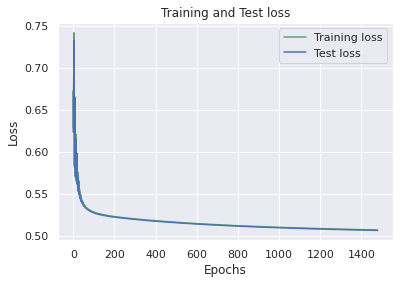

In [56]:
# visualize lost
# so sách giá trị cross entropy giữa 2 tập data_test, data_train sau khi train

import matplotlib.pyplot as plt

loss_train = train_costs
loss_test = test_costs
epochs = range(0,len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_test, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
print("- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TRAINING: ")
lo_cm, precision, recall, f1_score = score(training.rdd,theta)
#print ('Logistics Regression Accuracy Score: {0}'.format(acc))
print ('Precision: {0}'.format(precision))
print ('Recall: {0}'.format(recall))
print ('F1-score: {0}'.format(f1_score))





- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TRAINING: 
 True Positive : 41118
 False Positive : 11867
 False Negative : 3266
 True Negative : 6479
Precision: 0.7760309521562706
Recall: 0.926414924297044
F1-score: 0.8445809241134241


In [58]:
print("- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TEST: ")
lo_cm, precision, recall, f1_score = score(test.rdd,theta)
#print ('Logistics Regression Accuracy Score: {0}'.format(acc))
print ('Precision: {0}'.format(precision))
print ('Recall: {0}'.format(recall))
print ('F1-score: {0}'.format(f1_score))

- ĐỘ ĐO ĐÁNH GIÁ TRÊN TẬP TEST: 
 True Positive : 10331
 False Positive : 2967
 False Negative : 816
 True Negative : 1559
Precision: 0.7768837419160776
Recall: 0.9267964474746568
F1-score: 0.8452444262630394


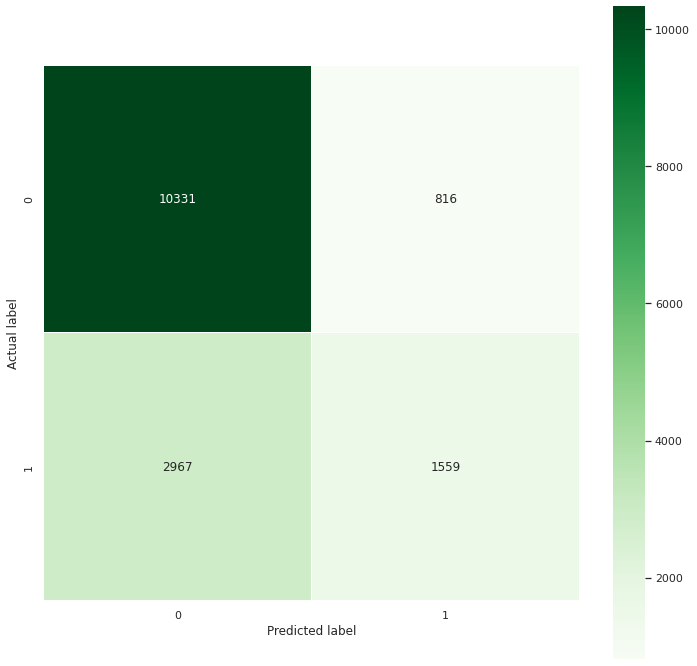

In [59]:
import seaborn as sns 

plt.figure(figsize=(12,12))
sns.heatmap(lo_cm,annot=True,fmt=".0f",linewidths=.5,square=True,cmap='Greens')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Confusion matrix trên tập test'